# 8.뉴스 요약봇 만들기

## 8-13. 프로젝트: 뉴스기사 요약해보기

---

## 목차

### Step 1. 데이터 수집하기

### Step 2. 데이터 전처리하기 (추상적 요약)

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

### Step 5. Summa을 이용해서 추출적 요약해보기

---

In [1]:
import nltk
nltk.download('stopwords')  # NLTK 패키지에서 불용어 사전 다운로드

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


## Step 1. 데이터 수집하기

데이터는 뉴스 기사 데이터([news_summary_more.csv](https://github.com/sunnysai12345/News_Summary))를 사용

=> 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성됨

- 추상적 요약: text 본문, headlines 이미 요약된 데이터로 삼아서 모델 학습
- 추출적 요약: 오직 text열만 사용하기

In [2]:
import urllib.request

# 데이터 다운
DATA_PATH = 'news_summarization/data/news_summary_more.csv'
if not os.path.exists(DATA_PATH):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename=DATA_PATH)

data = pd.read_csv(DATA_PATH, encoding='iso-8859-1')

In [3]:
# 랜덤 10개 샘플 출력
data.sample(10)

,headlines,text
23018,Computer virus halts iPhone chipmaker TSMC's f...,A computer virus on Friday night halted the pr...
77079,"Over 6,000 female defectors 'returned' to N Korea",In a report to the UN Committee on the Elimina...
13226,UP policeman who shouted 'Thain Thain' nominat...,"The UP police has hailed Manoj Kumar for his ""..."
98228,Trump blasts Snoop Dogg over clown shooting vi...,After rapper Snoop Dogg made a music video fea...
22065,SRK to narrate first 3 episodes of 'Kasautii.....,Shah Rukh Khan will introduce the lead charact...
34238,"Veg diet healthy, non-veg unhealthy: Health Mi...",The Health Ministry had recently posted an ima...
85882,216-kg ice cream sculpture displayed at Crimea...,Crimea's Sevastopol city hosted the first ever...
4880,Huawei gear to be removed from UK emergency se...,Britain's BT Group will remove Huawei equipmen...
25246,4-year-old allegedly raped by Congress leader'...,A four-year-old girl was allegedly raped by a ...
1250,"Noida, Gurugram have most number of unsold hom...",NCR's Gurugram and Noida have the most number ...


In [4]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


## 

## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

#### 데이터 중복 샘플 제거
- 유일값 개수 세기: pandas.unique()
- 중복 제거: pandas.drop_duplicates()

text 중복은 제거해야 함

text가 달라도 headlines는 같을 수 있어서 중복 제거X

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### Null 값 제거
- Null 개수 확인: data.isnull().sum()
- Null 제거: data.dropna()

다행히 현재 데이터에는 Null 값이 없음

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 텍스트 정규화와 불용어 제거
- 텍스트 정규화(text normalization)
    - 같은 의미 다른 표현의 단어를 같은 표현으로 통일시킴
    - => 기계 연산량 감소
    - [정규화 사전](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python) 구성

In [9]:
# 정규화 사전 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))  # 120

정규화 사전의 수:  120


- 불용어(stopwords)
    - 텍스트에 자주 등장하지만 자연어 처리에 실질적 도움이 되지 않는 단어
    - NLTK 제공 불용어 리스트 사용

In [10]:
# NLTK 제공 불용어 리스트
print('불용어 개수 :', len(stopwords.words('english') ))  # 179
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- 데이터 전처리
    - 모든 영어를 소문자로 변경
    - html 태그 제거
    - 정규 표현식 사용하여 각종 특수문자 제거
    - 불용어 제거
        - text 전처리에서만 사용
        - 자연스러운 요약을 위해 headlines는 불용어를 남김

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [12]:
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- 텍스트 정제 후 샘플 확인
    - empty 샘플 모두 Null 값으로 대체
    - Null 샘플 모두 제거

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


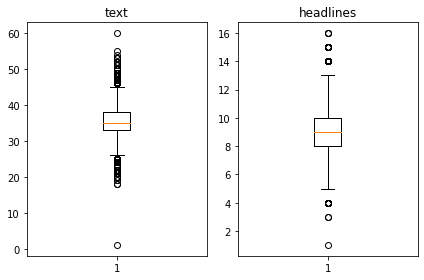

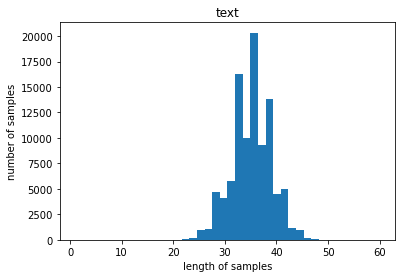

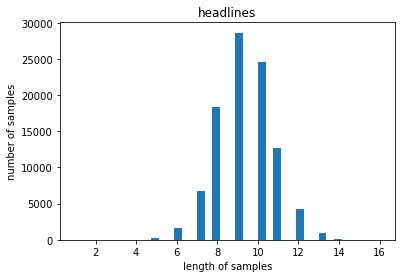

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))  # 1
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))  # 60
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))  # 35.09968483123221
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))  # 1
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))  # 16
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))  # 9.299532330215534

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

-text: 히스토그램을 보면 대체적으로 40 내외의 길이를 가짐

-headlines: 히스토그램을 보면 대체적으로 11 이하의 길이를 가짐

|column|min|max|int(mean)|
|:---:|:---:|:---:|:---:|
|text|1|60|35|
|headlines|1|16|9|

In [18]:
text_max_len = 40  # text 최대 길이 설정
headlines_max_len = 11  # headlines 최대 길이 설정
print('=3')

=3


- 설정한 길이가 몇 %의 샘플까지 포함하는지 확인

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [20]:
below_threshold_len(text_max_len, data['text'])  # 0.9750305002033347
below_threshold_len(headlines_max_len,  data['headlines'])  # 0.9880337535583571

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


- 정해진 길이보다 길면 제외

In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


- 시작 토큰(sostoken), 종료 토큰(eostoken) 추가
    - 디코더는 시작 토큰 입력받아서 문장 생성함, 종료 토큰 예측한 순간 멈춤
    - SOS(start of a sequence): 시작 토큰
        - sos 토큰이 맨 앞에 있는 문장: decoder_input
    - EOS(end of a sequence): 종료 토큰
        - eos 토큰이 맨 뒤에 있는 문장: decoder_target

In [22]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


- 인코더의 입력, 디코더의 입력, 레이블 모두 numpy 로 저장

In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


- 훈련 데이터, 테스트 데이터 분리
    - 방법1: 분리 패키지 사용
    - 방법2: 직접 코딩으로 분리

방법2를 사용하겠다.

In [24]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 정수 시퀀스로 데이터의 샘플 순서를 정의 => 샘플이 섞이게 된다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 섞인 데이터를 8:2 비율로 train, test 분리할 예정
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [25]:
# train, test 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


- 단어 집합(vocabulary) 생성 및 정수 인코딩
    - 단어 집합(vocabulary): 데이터의 각 단어를 고유한 정수로 맵핑하는 작업
    - Keras의 Tokenizer()로 생성할 수 있음
        - Tokenizer().fit_on_texts(데이터)  # 입력 데이터로부터 단어 집합 생성(동시에 각 단어에 고유한 정수가 부여됨)
    - encoder_input_train  # 원문 데이터
- 만들어진 단어 집합 중 빈도수가 낮은 단어 제외하기
    - src_tokenizer.word_index  # 현재 생성된 단어 집합
    - src_tokenizer.word_counts.items()  # 단어, 각 단어의 등장 빈도수
- 설정한 등장 빈도 값(threshold) 보다 작은 단어를 단어 집합과 훈련 데이터에서 제외
    - total_cnt - rare_cnt  # 등장 빈도가 적은 단어를 제외한 단어 집합 크기
    - Tokenizer(num_words=src_vocab) # 단어 집합의 크기 설정
- 정수인코딩 진행
    - decoder_input_train, decoder_target_train 에는 더 이상 len(tokenizer.word_index) 을 넘는 숫자는 존재하지 않음!
        - decoder_input_train: sostoken 추가된 상태
        - decoder_target_train: eostoken 추가된 상태
    - => 빈도수가 낮은 단어가 삭제됨
    - => 빈도수가 낮은 단어만으로 구성된 샘플은 empty 샘플이 되었을 가능성이 있다. 주로 text 보다는 headlines 에서 나타날 것이다.
    - => headlines 에서 길이가 0이 된 샘플 인덱스 찾아야 함!
    - => sostoken or eostoken 추가된 상태라서 길이가 1인 상태인 샘플 인덱스를 찾으면 됨!!

#### 'text' 에 대한 처리

In [26]:
# 'text'
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [27]:
# 만들어진 단어 집합 중 희귀 단어(한계값 미만) 등장 빈도 비율 관련 내용 출력

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64641
등장 빈도가 6번 이하인 희귀 단어의 수: 44104
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20537
단어 집합에서 희귀 단어의 비율: 68.2291424947015
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7834991612694067


In [28]:
src_vocab = 20000  # 등장 빈도가 적은 단어를 제외한 단어 집합 크기

src_tokenizer = Tokenizer(num_words=src_vocab)  # 단어 집합 크기 설정해서 다시 생성
src_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2547, 5970, 2855, 102, 2611, 916, 3959, 30, 66, 186, 11373, 426, 3959, 416, 6266, 5970, 3959, 2014, 2504, 916, 916, 919, 32, 5970, 4438, 1372, 802], [2202, 4884, 2408, 1152, 2031, 1049, 49, 3077, 4938, 840, 4557, 10827, 1767, 301, 422, 3077, 2725, 2031, 588, 137, 2101, 4383, 2101, 301, 512, 523, 4032, 301, 717, 3136], [671, 298, 587, 389, 1365, 265, 265, 4744, 3415, 39, 61, 214, 35, 595, 808, 8290, 389, 1365, 583, 1104, 187, 783, 2504, 983, 8290, 1365, 583, 187, 858, 983, 2951, 2042, 3147, 4010, 3415]]


##### 'headlines' 에 대한 처리

In [30]:
# 'headlines'
tar_tokenizer = Tokenizer() # 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [31]:
# 만들어진 단어 집합 중 희귀 단어(한계값 미만) 등장 빈도 비율 관련 내용 출력

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28467
등장 빈도가 5번 이하인 희귀 단어의 수: 18775
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9692
단어 집합에서 희귀 단어의 비율: 65.95356026276039
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.185495106517886


In [32]:
tar_vocab = 10000  # 등장 빈도가 적은 단어를 제외한 단어 집합 크기

tar_tokenizer = Tokenizer(num_words=tar_vocab)  # 단어 집합 크기 설정해서 다시 생성
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)
print('=3')

=3


In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 5971, 699, 917, 3960, 5, 152, 31], [1, 108, 3078, 886, 4558, 520, 26, 22, 423, 2203], [1, 390, 57, 42, 266, 3, 266, 4745, 3416, 4, 99], [1, 23, 1453, 119, 5, 2333, 473, 738], [1, 7091, 3, 827, 188, 13, 1319, 3618, 34]]
target
decoder  [[5971, 699, 917, 3960, 5, 152, 31, 2], [108, 3078, 886, 4558, 520, 26, 22, 423, 2203, 2], [390, 57, 42, 266, 3, 266, 4745, 3416, 4, 99, 2], [23, 1453, 119, 5, 2333, 473, 738, 2], [7091, 3, 827, 188, 13, 1319, 3618, 34, 2]]


In [34]:
# 길이 0인 샘플 인덱스 저장 => token 추가해놔서 실질적으로 길이 1인 샘플이다.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# 길이 0인 샘플 인덱스(=token 추가로 인해 실질적으로 길이 1인 샘플 인덱스) 삭제
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

# 샘플 삭제 결과 확인
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


- 패딩하기
    - 짧은 데이터는 뒤에 숫자 0을 넣어서 최대 길이에 맞춘다.

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


- 기본적인 seq2seq 모델 설계
    - 기본적인 seq2seq 모델: hidden state, cell state 를 디코더의 초기 state 로 사용
    - 인코더
        - 함수형 API를 이용해서 인코더 설계
        - 무조건 LSTM 의 capacity 값이 크다고 해서 성능이 반드시 올라가는 것은 아니다.
        - 총 3개의 층 => 모델 용량 증가
        - overfitting 방지: dropout + recurrent_dropout => Variational Dropout
        - recurrent_dropout 은 cuDNN 을 사용할 수 없음 => 학습 시간 오래 걸림
    - 디코더 설계
        - 디코더의 LSTM의 입력을 정의할 때, initial_state 인자값으로 인코더의 hidden state 와 cell state 값을 넣어야 한다.
        - 디코더 출력층에서는 tar_vocab 의 수많은 단어 중 하나를 선택하는 다중 클래스 분류 문제를 푼다.
        - => Dense(tar_vocab, activation='softmax')
        - 디코더의 출력층 설계에 어텐션 메커니즘을 적용하면 성능을 높일 수 있다!

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

인코더 설계

In [37]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256  # LSTM의 capacity == LSTM의 용량 크기(뉴런 개수)

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더 설계

In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM: initial_state 인자값으로 인코더의 hidden state, cell state 값을 넣어야 함!
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [39]:
# 디코더의 출력층
# tar_vocab 의 여러 단어 중 하나를 선택해야 하는 다중 클래스 분류 문제라서 Dense(tar_vocab, activation='softmax') 사용
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

- 어텐션 층을 만들어서 앞서 설계한 디코더 출력층을 수정함
    - 인코더, 디코더의 hidden state 들을 어텐션 함수의 입력으로 사용
    - 어텐션 함수가 리턴한 값을 predict 할 때 디코더의 hidden state 와 함께 활용함
    - 어텐션 함수 설계 == 다른 새로운 신경망 설계

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

- 모델 훈련
    - EarlyStopping
        - callbacks=[es]: 특정 조건이 충족되면 훈련을 멈추는 역할
        - es == EarlyStopping(monitor='val_loss', patience=2, verbose=1)
        - => val_loss(검증 데이터 손실) 관찰하다가 값이 작아지지 않고 증가하는 현상이 2번(patience=2) 관측되면 학습 종료
        - => epoch 값이 커도 최적점에서 훈련 종료 가능

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 241s 870ms/step - loss: 6.0500 - val_loss: 5.6038
Epoch 2/50
269/269 [==============================] - 231s 858ms/step - loss: 5.4760 - val_loss: 5.2548
Epoch 3/50
269/269 [==============================] - 234s 871ms/step - loss: 5.1222 - val_loss: 4.9711
Epoch 4/50
269/269 [==============================] - 232s 862ms/step - loss: 4.8447 - val_loss: 4.7775
Epoch 5/50
269/269 [==============================] - 236s 876ms/step - loss: 4.6289 - val_loss: 4.6148
Epoch 6/50
 55/269 [=====>........................] - ETA: 2:55 - loss: 4.4404

- train_loss, val_loss 시각화

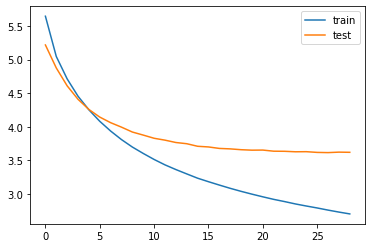

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 인퍼런스 모델 구현
    - test 할 때, 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원 필요
    - => 사전 3개 준비
    - seq2seq
        - 훈련할 때, 동작(인퍼런스 단계)할 때 방식이 다름 => 모델 설계 별개로 진행해야 함
        - 훈련 단계: 인코더와 디코더를 엮은 모델
        - 인퍼런스 단계
            - 정답 문장 없음
            - => 만들어야 할 문장 길이만큼 디코더가 반복 구조로 동작해야 함
            - => 인퍼런스를 위한 모델 설계 별도로 진행
            - => 인코더 모델, 디코더 모델 분리해서 설계

사전 3개 준비

In [ ]:
# 사전 3개
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


훈련 단계: 인코더와 디코더를 엮은 모델 설계

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


인퍼런스 단계: 인코더 모델, 디코더 모델 분리해서 설계

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : centre thursday directed ntpc limited procure stubble rate per tonne farmers move aimed countering increasing levels pollution delhi national capital region crop residue used energy mix power generation power plants power minister rk singh said 
실제 요약 : ntpc to procure stubble at per tonne from farmers 


NameError: name 'summary_max_len' is not defined

비교 작성

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
text = pd.read_csv(DATA_PATH, encoding='iso-8859-1')

In [ ]:
print(text[:1500])

In [ ]:
for i in range(50, 100):
    print("원문 :", text['text'][i])
    print("실제 요약 :", text['headlines'][i])
    print("추출적 요약 :", summarize(text, ratio=0.2))
    print("\n")

비교 작성

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
텍스트 전처리 및 모델 학습이 오래 걸려서 기다리는 시간이 길었다. 컴퓨터가 굉음을 내면서 돌아가고 있다. 병렬 프로그래밍을 설정하려다가 끝낼 수 없을 것 같아서 일단 제출했다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|평가문항|상세기준|
>|:---:|:---:|
>|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
>|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
>|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|



### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
병렬 프로그래밍 구현하는 방법을 찾아봐야 겠다.